<a href="https://colab.research.google.com/github/naiaraAM/ML_project_UT/blob/main/Project_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Set up enviroment


# Download data


In [6]:
import pandas as pd
import numpy as np

In [2]:
!unzip -q playground-series-s4e6.zip -d data
!rm playground-series-s4e6.zip

unzip:  cannot find or open playground-series-s4e6.zip, playground-series-s4e6.zip.zip or playground-series-s4e6.zip.ZIP.
rm: playground-series-s4e6.zip: No such file or directory


In [7]:
from sklearn.model_selection import train_test_split
train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')

print(f"The train data has {train_data.shape[0]} rows and {train_data.shape[1]} columns")
print(f"The test data has {test_data.shape[0]} rows and {test_data.shape[1]} columns")

The train data has 76518 rows and 38 columns
The test data has 51012 rows and 37 columns


<font color='red'>Do your code in the cell bellow your name, so we don't have merge issues. We can merge on friday's meeting</font>


# Data

In [8]:
import matplotlib.pyplot as plt

# We will re-use this code in the future
def plot_class_distribution(y, title="Class Distribution"):

    class_counts = y.value_counts()

    class_counts.plot(kind='bar', color=['skyblue', 'orange', 'red'])
    plt.title(title, fontsize=14)
    plt.xlabel("Class", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.xticks(rotation=0, fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()
    plt.show()

In [9]:
X, Y = train_data.drop(columns=['id', 'Target']), train_data['Target']
X.shape, Y.shape, train_data.shape

((76518, 36), (76518,), (76518, 38))

In [10]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, random_state = 111, test_size = 0.20)
X_train.shape, Y_train.shape, X_val.shape, Y_val.shape

((61214, 36), (61214,), (15304, 36), (15304,))

In [11]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_Scaled = scaler.fit_transform(X_train) # normalize data

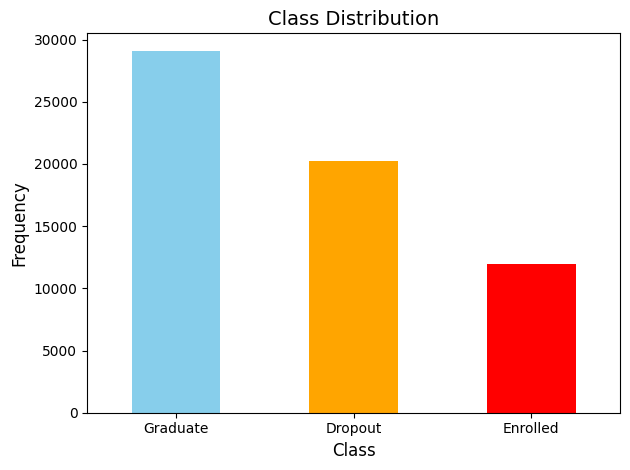

In [12]:
plot_class_distribution(Y_train)

In [13]:
from imblearn.over_sampling import SMOTE
X_over, y_over = SMOTE().fit_resample(X_Scaled, Y_train)

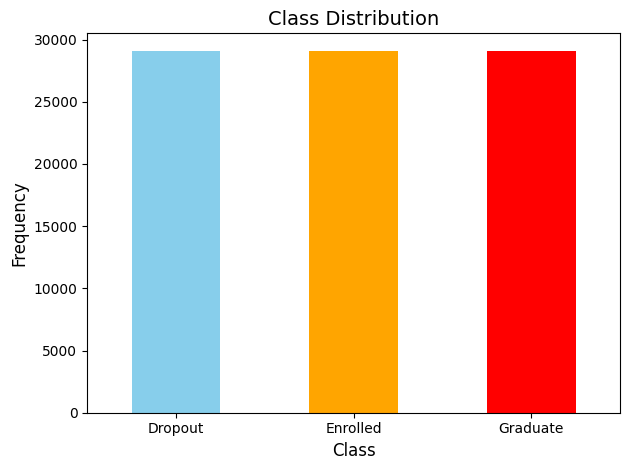

In [14]:
plot_class_distribution(y_over)

In [15]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_over)
y_val_encoded = label_encoder.fit_transform(Y_val)

In [16]:
test_data = pd.read_csv('data/test.csv')
X_test = test_data.drop(columns=['id'])
X_test_scaled = scaler.transform(X_test)
X_val_Scaled = scaler.transform(X_val)

## Naiara


Non-equal performance on public-private score, public is always better

In [35]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier

gbc_model = GradientBoostingClassifier(n_estimators=350, learning_rate=0.03, max_depth=5)
gbc_model.fit(X_over, y_encoded)

GradientBoostingClassifier(learning_rate=0.03, max_depth=5, n_estimators=350)

In [36]:
y_test_gbc = gbc_model.predict(X_test_scaled)
y_test_gbc = label_encoder.inverse_transform(y_test_gbc)

submission = pd.DataFrame(
    {'id': test_data["id"], 'Target': y_test_gbc},
    columns=['id', 'Target']
)
submission.to_csv('submission.csv', index=False)
print("Submission file saved as 'submission.csv'")

Submission file saved as 'submission.csv'


## Juan

In [37]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
import numpy as np

### Bagger


In [33]:
bagger = BaggingClassifier(estimator=DecisionTreeClassifier(), max_samples=1.0, n_estimators=9, random_state=1111)
score = cross_val_score(bagger, X_Scaled, Y, cv=4)
print(f'Average validation accuracy is {np.mean(score)*100}%')

Average validation accuracy is 70.09047692726553%


### Random forest


In [45]:
randomF1000 = RandomForestClassifier(n_estimators=1000, max_features="sqrt")
randomF1000.fit(X_train,Y_train)
randomF1000.score(X_val, Y_val)

0.8275614218504966

In [21]:
def submitModel(model, X_test):
    X_test_for_predicting = X_test.drop(columns=['id'])
    Y_tilda = model.predict(X_test_for_predicting)
    submission = pd.DataFrame(
        {'id': X_test["id"], 'Target': Y_tilda},
        columns = ['id', 'Target'])
    submission.to_csv('submission.csv', index = False)

In [47]:
submitModel(randomF1000, test_data) #0.82994
#submitModel(randomF100, test_data) #0.82523

### Trying with scaling data

In [22]:
submitModel(randomF1000, test_data)

### Trying LGBM

In [38]:
from lightgbm import  LGBMClassifier

params = {
    'objective': 'multiclass',
    'num_class': 3,
    'boosting_type': 'gbdt',
    'metric': 'multi_logloss',
    'learning_rate': 0.01,
    'num_leaves': 1000,
    'seed': 555545454,
    # "num_threads": 4
}

# Train the LightGBM model
lgb_model = LGBMClassifier(
    **params
)

lgb_model.fit(X_over, y_encoded)

lgb_model_y_pred = lgb_model.predict(X_test_scaled)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005495 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7697
[LightGBM] [Info] Number of data points in the train set: 87138, number of used features: 36
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


In [40]:
lgb_result = label_encoder.inverse_transform(lgb_model_y_pred.astype(int))
submission = pd.DataFrame(
    {'id': test_data["id"], 'Target': lgb_result},
    columns=['id', 'Target']
)
submission.to_csv('juan.csv', index=False)
print("Submission file saved as 'submission.csv'")

Submission file saved as 'submission.csv'


### a

In [ ]:
import lightgbm as lgb
# Create a dataset for LightGBM
lgb_train_data = lgb.Dataset(X_over, label=y_encoded)
lgb_test_data = lgb.Dataset(X_val_Scaled, label=y_val_encoded, reference=lgb_train_data)

# Define LightGBM parameters
params = {
    'objective': 'multiclass',
    'num_class': 3,
    'boosting_type': 'gbdt',
    'metric': 'multi_logloss',
    'learning_rate': 0.01,
    'num_leaves': 1000,
    'seed': 555545454,
    # "num_threads": 4
}

# Train the LightGBM model
lgb_model = lgb.train(
    params,
    lgb_train_data,
    num_boost_round=1000,
    valid_sets=[lgb_test_data],
)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003077 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7672
[LightGBM] [Info] Number of data points in the train set: 87138, number of used features: 36
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

Exception ignored on calling ctypes callback function: <function _log_callback at 0x177b068b0>
Traceback (most recent call last):
  File "/Users/jquirozcadavid/Library/Python/3.9/lib/python/site-packages/lightgbm/basic.py", line 257, in _log_callback
    def _log_callback(msg: bytes) -> None:
KeyboardInterrupt: 


No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

In [44]:
y_pred_LGBM = lgb_model.predict(X_test)
y_pred_LGBM_labels = [list(p).index(max(p)) for p in y_pred_LGBM]

In [45]:
y_test_LGBM = label_encoder.inverse_transform(y_pred_LGBM_labels)

In [46]:
submission = pd.DataFrame(
    {'id': test_data["id"], 'Target': y_test_LGBM},
    columns=['id', 'Target']
)
submission.to_csv('submission.csv', index=False)
print("Submission file saved as 'submission.csv'")

Submission file saved as 'submission.csv'


In [29]:
y_pred_val = lgb_model.predict(X_val_Scaled)
y_pred_val_labels = [list(p).index(max(p)) for p in y_pred_val]

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_val_encoded, y_pred_val_labels))

              precision    recall  f1-score   support

           0       0.90      0.84      0.87      5084
           1       0.66      0.61      0.63      2984
           2       0.86      0.92      0.89      7236

    accuracy                           0.83     15304
   macro avg       0.80      0.79      0.80     15304
weighted avg       0.83      0.83      0.83     15304



## Fidan


In [17]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import xgboost as xgb
from sklearn.metrics import accuracy_score

In [23]:
dtrain = xgb.DMatrix(X_over, label=y_encoded)
dval = xgb.DMatrix(X_val_Scaled, label=y_val_encoded)
dtest = xgb.DMatrix(X_test_scaled)

In [24]:
params = {
    "objective": "multi:softmax", 
    "num_class": len(np.unique(y_encoded)), 
    "eval_metric": "mlogloss",
    "eta": 0.1, 
    "max_depth": 6 
}

In [25]:
num_boost_round = 100
early_stopping_rounds = 10
evals = [(dtrain, 'train'), (dval, 'eval')]

In [26]:
model = xgb.train(params, dtrain, num_boost_round, evals=evals, early_stopping_rounds=early_stopping_rounds)

[0]	train-mlogloss:1.01471	eval-mlogloss:1.01509
[1]	train-mlogloss:0.94439	eval-mlogloss:0.94538
[2]	train-mlogloss:0.88484	eval-mlogloss:0.88618
[3]	train-mlogloss:0.83304	eval-mlogloss:0.83503
[4]	train-mlogloss:0.78877	eval-mlogloss:0.79097
[5]	train-mlogloss:0.75049	eval-mlogloss:0.75291
[6]	train-mlogloss:0.71669	eval-mlogloss:0.71967
[7]	train-mlogloss:0.68728	eval-mlogloss:0.69083
[8]	train-mlogloss:0.66130	eval-mlogloss:0.66534
[9]	train-mlogloss:0.63818	eval-mlogloss:0.64277
[10]	train-mlogloss:0.61778	eval-mlogloss:0.62298
[11]	train-mlogloss:0.59967	eval-mlogloss:0.60544
[12]	train-mlogloss:0.58369	eval-mlogloss:0.58996
[13]	train-mlogloss:0.56952	eval-mlogloss:0.57626
[14]	train-mlogloss:0.55641	eval-mlogloss:0.56396
[15]	train-mlogloss:0.54477	eval-mlogloss:0.55314
[16]	train-mlogloss:0.53423	eval-mlogloss:0.54337
[17]	train-mlogloss:0.52484	eval-mlogloss:0.53469
[18]	train-mlogloss:0.51639	eval-mlogloss:0.52708
[19]	train-mlogloss:0.50819	eval-mlogloss:0.51980
[20]	train

In [41]:
def submitModelPredictedLabels(predicted_labels, X_test):
    submission = pd.DataFrame(
        {'id': X_test["id"], 'Target': predicted_labels},
        columns = ['id', 'Target'])
    submission.to_csv('fidan.csv', index = False)

In [ ]:
y_test_pred = model.predict(dtest)
xgb_result = label_encoder.inverse_transform(y_test_pred.astype(int))

In [43]:
submitModelPredictedLabels(xgb_result, test_data)

# evaluate the model

In [44]:
assabler = pd.DataFrame()
assabler["model1"] = y_test_gbc
assabler["model2"] = lgb_result
assabler["model3"] = xgb_result

In [45]:
assabler["model1"]

0         Dropout
1        Graduate
2        Graduate
3        Enrolled
4        Enrolled
           ...   
51007     Dropout
51008     Dropout
51009     Dropout
51010     Dropout
51011     Dropout
Name: model1, Length: 51012, dtype: object

In [46]:
assabler["model2"]

0         Dropout
1        Graduate
2        Graduate
3        Enrolled
4        Enrolled
           ...   
51007     Dropout
51008     Dropout
51009     Dropout
51010     Dropout
51011     Dropout
Name: model2, Length: 51012, dtype: object

In [47]:
assabler["model3"]

0         Dropout
1        Graduate
2        Graduate
3        Enrolled
4        Enrolled
           ...   
51007     Dropout
51008     Dropout
51009     Dropout
51010     Dropout
51011     Dropout
Name: model3, Length: 51012, dtype: object

In [50]:
def submitAssembler(predicted_labels, X_test):
    submission = pd.DataFrame(
        {'id': X_test["id"], 'Target': predicted_labels},
        columns = ['id', 'Target'])
    submission.to_csv('assembler.csv', index = False)

In [51]:
assabler['ensemble'] = assabler[["model1", "model2", "model3"]].mode(axis=1)[0]
print(assabler['ensemble'].head())
submitAssembler(assabler['ensemble'], test_data)

0     Dropout
1    Graduate
2    Graduate
3    Enrolled
4    Enrolled
Name: ensemble, dtype: object
